# What is `vcdisk`?

`vcdisk` is a handy toolbox which implements several essential routines for anyone working on galactic dynamics and, in particular, with galaxy rotation curves. `vcdisk` provides fast and efficient solutions of Poisson's equation (using results from [Casertano 1983](https://ui.adsabs.harvard.edu/abs/1983MNRAS.203..735C/), [Cuddeford 1993](https://ui.adsabs.harvard.edu/abs/1993MNRAS.262.1076C/), [Noordermeer 2008](https://ui.adsabs.harvard.edu/abs/2008MNRAS.385.1359N/) and [Binney & Tremaine 2008](https://ui.adsabs.harvard.edu/abs/2008gady.book.....B/)) in the context of thick galaxy disks and flattened oblate bulges of any observed surface density profile.

It is a new minimial python package that I wrote and it can be found at [https://github.com/lposti/vcdisk](https://github.com/lposti/vcdisk). This notebook reproduces the introductory *"How to use `vcdisk`"* tutorial which can be found in the [**documentation**](https://vcdisk.readthedocs.io/en/latest/).

## Why do we need `vcdisk`?

The most typical use case for `vcdisk` is in rotation curve modelling. Specifically, this module allows to compute *the contribution to the circular velocity of the observed baryonic components of a disk galaxy*, e.g. the stellar disk, the gas disk, the stellar bulge.

If we have some kinematical observations that allowed us to measure the rotational velocities of some material in circular orbits in the disk of a spiral galaxy (e.g. cold gas), the observed rotation curve can be decomposed into several dynamically important components in the galaxy
![Rotation curve decomposition](figures/vrot.png)
where $V_{\rm DM}$ is the contribution from dark matter, $V_{\star,\rm disk}$ from the stellar disk, $V_{\rm gas, disk}$ from the gas disk etc. 
While the left-hand side of this equation usually comes from observations, and the contribution of DM is the unknown that is often what we want to constrain, for all the other terms there is ``vcdisk``!

``vcdisk`` calculates the contribution to the gravitational field of an axisymmetric component whose radial surface density distribution is known. For instance, the surface density profiles of stellar ($\Sigma_{\star, \rm disk}$) and gaseous disks ($\Sigma_{\star, \rm disk}$) can be directly obtained from galaxy images in appropriate wavebands and these can then be used as input for ``vcdisk.vcdisk`` to calculate $V_{\rm disk}(R, \Sigma_{\rm disk}(R))$.

The ``vcdisk`` module provides appropriate calculations for both disky (`vcdisk.vcdisk`) and spheroidal (`vcdisk.vcbulge`) galaxy components.

## Example 1: analytic surface density

### Import `vcdisk`

In [1]:
import vcdisk

import numpy as np
import matplotlib.pylab as plt

# suppressing warnings in the scipy.integrate.quad calls in vcbulge
import warnings
from scipy.integrate import IntegrationWarning
warnings.filterwarnings("ignore", category=IntegrationWarning)

### Exponential thick disk

Let's start with the case of a thick disk with a classical exponential surface density.

In [2]:
md, rd = 1e10, 2.0                        # mass, scalelength of the disk
r = np.linspace(0.1, 30.0, 100)           # radii samples

def expdisk_sb(r, md, rd):
    # exponential disk surface density
    return md / (2*np.pi*rd**2) * np.exp(-r/rd)

sb_exp = expdisk_sb(r, md, rd)

# run vcdisk
vdisk = vcdisk.vcdisk(r, sb_exp)

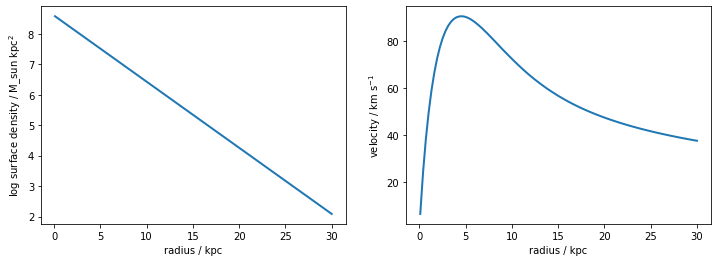

In [3]:
def plot_sb_vdisk(ax, r, sb, vdisk, label=None):
    ax[0].plot(r, np.log10(sb), lw=2)
    ax[0].set_xlabel("radius / kpc");
    ax[0].set_ylabel("log surface density / M_sun kpc"+"$^{2}$");

    ax[1].plot(r, vdisk, lw=2,  label=label)
    ax[1].set_xlabel("radius / kpc");
    ax[1].set_ylabel("velocity / km s"+"$^{-1}$");
    if label is not None: ax[1].legend()

fig,ax = plt.subplots(figsize=(12,4), ncols=2)
plot_sb_vdisk(ax, r, sb_exp, vdisk)

We can explore how does $V_{\rm disk}$ change when changing the scaleheight of the disk $z_0$ for instance:

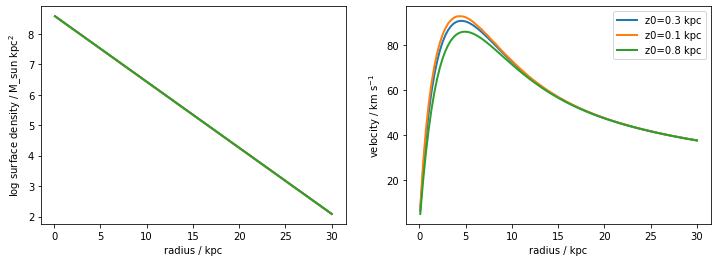

In [4]:
fig,ax = plt.subplots(figsize=(12,4), ncols=2)
plot_sb_vdisk(ax, r, sb_exp, vdisk, label='z0=0.3 kpc')
plot_sb_vdisk(ax, r, sb_exp, vcdisk.vcdisk(r, sb_exp, z0=0.1), label='z0=0.1 kpc')
plot_sb_vdisk(ax, r, sb_exp, vcdisk.vcdisk(r, sb_exp, z0=0.8), label='z0=0.8 kpc')

### Sersic profile

Let's compare to other popular analytic surface density profiles. Probably the most used in Astronomy is the [Sersic (1968)](https://ui.adsabs.harvard.edu/abs/1968adga.book.....S) profile, which is often used to describe all sorts of stellar components, including disks and bulges. We can use the class `sersic` in the `vcdisk` package to get Sersic profiles

In [5]:
sers_n1  = vcdisk.sersic(md, 1.678*rd, 1.0)
sers_n2  = vcdisk.sersic(md, 1.678*rd, 2.0)
sers_n05 = vcdisk.sersic(md, 1.678*rd, 0.5)
sers_n4  = vcdisk.sersic(md, 1.678*rd, 4.0)

Here, we have taken the reference model `sers_n1` which is equivalent to the exponential disk above, since $R_e\simeq 1.678 R_{\rm d}$ for $n=1$ exponential profiles. Let's now compare the circular velocities of disks with Sersic surface brightnesses with different index $n$, while keeping the total luminosity fixed.

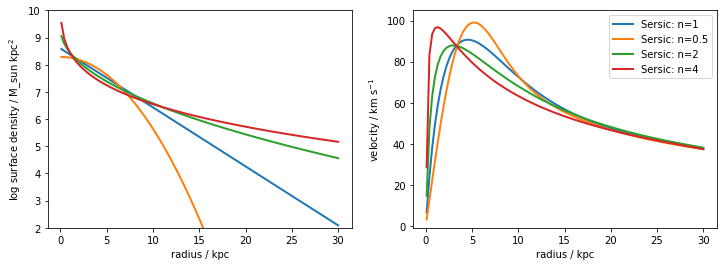

In [6]:
fig,ax = plt.subplots(figsize=(12,4), ncols=2)
plot_sb_vdisk(ax, r, sers_n1(r),  vcdisk.vcdisk(r, sers_n1(r)), label='Sersic: n=1')
plot_sb_vdisk(ax, r, sers_n05(r), vcdisk.vcdisk(r, sers_n05(r)), label='Sersic: n=0.5')
plot_sb_vdisk(ax, r, sers_n2(r),  vcdisk.vcdisk(r, sers_n2(r)), label='Sersic: n=2')
plot_sb_vdisk(ax, r, sers_n4(r),  vcdisk.vcdisk(r, sers_n4(r)), label='Sersic: n=4')
ax[0].set_ylim(2,10);
ax[1].set_ylim(-1, 105);

### Sersic bulges

We have just computed the circular velocities of thick galaxy disks whose surface brightness profile is of the Sersic form with different $n$. However, we may also be interested in the circular velocity of a **spheroidal component**, *like a stellar bulge*, whose observed surface brightness is well approximated by a Sersic law.

#### If for disky components we use `vcdisk`, for spheroidal components we use `vcbulge`!

Let's now compute the circular velocity on the mid-plane of a nearly spherical Sersic bulges with different $n$.

/Users/lposti/anaconda/envs/py37/lib/python3.7/site-packages/vcdisk.py:925: RuntimeWarning: invalid value encountered in double_scalars
  return -self.Ie*self.bn/(self.n*self.re) * np.exp(-self.bn*((R/self.re)**(1/self.n)-1)) * (R/self.re)**(1/self.n-1.0)


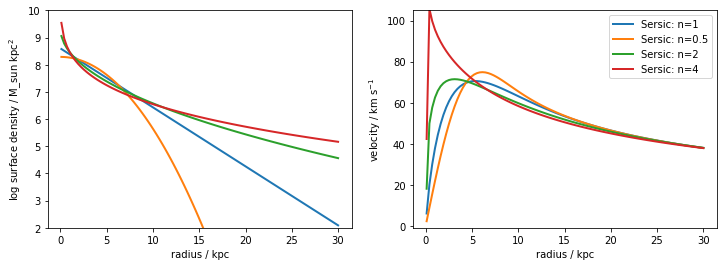

In [7]:
fig,ax = plt.subplots(figsize=(12,4), ncols=2)
plot_sb_vdisk(ax, r, sers_n1(r),  vcdisk.vcbulge_sersic(r, md, 1.678*rd, 1.0), label='Sersic: n=1')
plot_sb_vdisk(ax, r, sers_n05(r), vcdisk.vcbulge_sersic(r, md, 1.678*rd, 0.5), label='Sersic: n=0.5')
plot_sb_vdisk(ax, r, sers_n2(r),  vcdisk.vcbulge_sersic(r, md, 1.678*rd, 2.0), label='Sersic: n=2')
plot_sb_vdisk(ax, r, sers_n4(r),  vcdisk.vcbulge_sersic(r, md, 1.678*rd, 4.0), label='Sersic: n=4')
ax[0].set_ylim(2,10);
ax[1].set_ylim(-1, 105);

### Flattened Sersic bulges

We can compute the circular velocity also for flattened oblate bulges, thus for components whose 3D density is stratified as $\rho=\rho(m)$ where $m^2=R^2+z^2/q^2$ with axis ratio $0<q\leq 1$.

Let's take the same baseline model as in Fig. 2 (top central panel) of [Noordermeer (2008)](https://ui.adsabs.harvard.edu/abs/2008MNRAS.385.1359N/):

In [8]:
mb, re = 5e9, 1.0                    # mass, effective radius of the bulge
rb = np.logspace(-2, 1, 100)          # radii samples

sers_bulge = vcdisk.sersic(mb, re, 1.0)
sb_sers_bulge = sers_bulge(rb)

and we can plot $V_{\rm bulge}$ for different axis ratios $q$ at a fixed mass, effective radius and Sersic index. For comparison, the black dotted line is for a point mass with the same mass as the bulge.

CPU times: user 52 s, sys: 541 ms, total: 52.5 s
Wall time: 54.5 s


Text(0, 0.5, 'velocity / km s$^{-1}$')

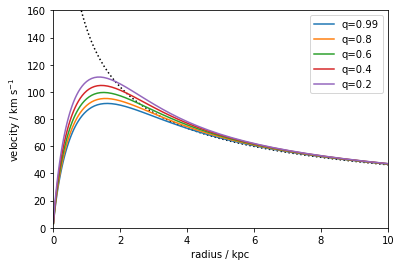

In [9]:
%%time
plt.plot(rb, np.sqrt(4.301e-6*5e9/rb),'k:')
plt.plot(rb, vcdisk.vcbulge(rb, sb_sers_bulge), c='C0', label='q=0.99')
plt.plot(rb, vcdisk.vcbulge(rb, sb_sers_bulge, q=0.8), c='C1', label='q=0.8')
plt.plot(rb, vcdisk.vcbulge(rb, sb_sers_bulge, q=0.6), c='C2', label='q=0.6')
plt.plot(rb, vcdisk.vcbulge(rb, sb_sers_bulge, q=0.4), c='C3', label='q=0.4')
plt.plot(rb, vcdisk.vcbulge(rb, sb_sers_bulge, q=0.2), c='C4', label='q=0.2')
plt.legend()
plt.ylim(0,160);
plt.xlim(0,10);
plt.xlabel("radius / kpc");
plt.ylabel("velocity / km s"+"$^{-1}$");

### User-defined vertical density profile

`vcdisk` allows us to specify our own vertical density profile, if we so choose. This can be easily done through the `rhoz` argument.

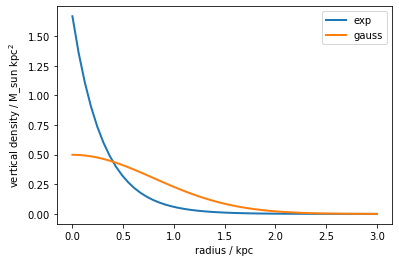

In [10]:
def rhoz_gauss(z, m, std): return np.exp(-0.5*(z-m)**2/std**2) / np.sqrt(2*np.pi*std**2)

def plot_rhoz(ax, z, rhoz, label=None):
    ax.plot(z, rhoz, lw=2, label=label)
    ax.legend()
    ax.set_xlabel("radius / kpc");
    ax.set_ylabel("vertical density / M_sun kpc"+"$^{2}$");


fig, ax = plt.subplots(figsize=(6,4))
z = np.linspace(0,3)
plot_rhoz(ax, z, np.exp(-z/0.3) / (2*0.3), label='exp')
plot_rhoz(ax, z, rhoz_gauss(z, 0., 0.8), label='gauss')

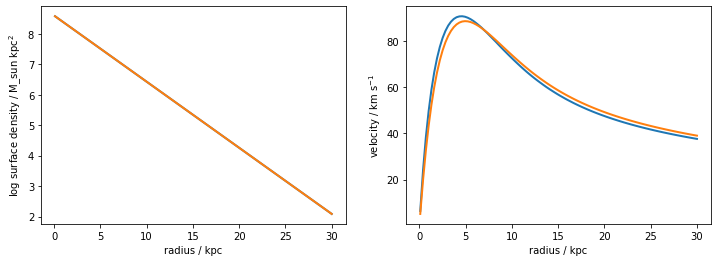

In [11]:
fig,ax = plt.subplots(figsize=(12,4), ncols=2)

plot_sb_vdisk(ax, r, sb_exp, vdisk)
plot_sb_vdisk(ax, r, sb_exp, vcdisk.vcdisk(r, sb_exp, rhoz=rhoz_gauss, rhoz_args={'m':0.0, 'std':0.8}))

### Flaring disk

We can also have a flaring disk, i.e. one where the vertical density depends also on radius $\rho_z=\rho_z(z,R)$. We can work out this case as well with `vcdisk` by specifying how $\rho_z$ depends on $R$.

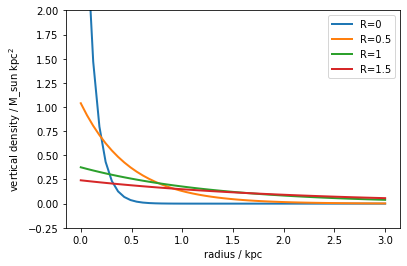

In [12]:
def rhoz_exp_flaring(z, R, z00, Rs):
    z0R = z00+np.arcsinh(R**2/Rs**2)
    return np.exp(-z/z0R) / (2*z0R)

fig, ax = plt.subplots(figsize=(6,4))
z = np.linspace(0,3)
plot_rhoz(ax, z, rhoz_exp_flaring(z, 0.0, 0.1, 0.8), label='R=0')
plot_rhoz(ax, z, rhoz_exp_flaring(z, 0.5, 0.1, 0.8), label='R=0.5')
plot_rhoz(ax, z, rhoz_exp_flaring(z, 1.0, 0.1, 0.8), label='R=1')
plot_rhoz(ax, z, rhoz_exp_flaring(z, 1.5, 0.1, 0.8), label='R=1.5')
plt.ylim(None,2);

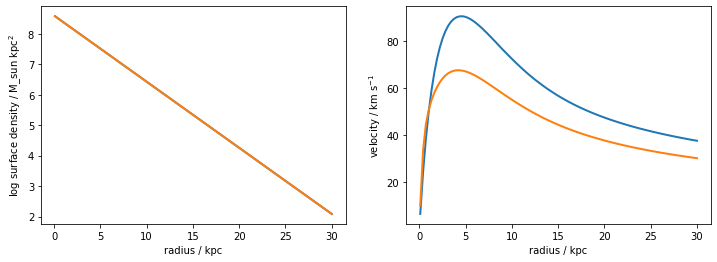

In [13]:
fig,ax = plt.subplots(figsize=(12,4), ncols=2)

plot_sb_vdisk(ax, r, sb_exp, vdisk)
plot_sb_vdisk(ax, r, sb_exp, vcdisk.vcdisk(r, sb_exp, rhoz=rhoz_exp_flaring, rhoz_args={'z00':0.1, 'Rs':0.8}, flaring=True))

## Example 2: observed surface brightness

### NGC2403: a late (Sc) bulgeless disk galaxy

Let's say that, instead of having just simple galaxy images from which we can derive an analytic approximation for the galaxy surface brightness, we have a detailed galaxy image from which we can measure the intensity in elliptical annuli. This is for instance the case of nearby galaxies such as [NGC 2403](http://cdsportal.u-strasbg.fr/?target=ngc2403), that I use here as an example.

I use data taken from the [SPARC](http://astroweb.cwru.edu/SPARC/) database for this galaxy, which I include in this package as the `NGC2403_rotmod.dat` file. Here are reported measurements of the intensity at 3.6$\mu$m taken with the *SPITZER* space telescope in elliptical annuli for this target.

In [14]:
rad, _, _, _, _, _, sb_n2403, _ = np.genfromtxt('NGC2403_rotmod.dat', unpack=True)
# convert SB to Msun / kpc^2
sb_n2403 *= 1e6

Now we can very easily use `vcdisk` to calculate $V_{\star, \rm disk}$ for this galaxy, and we can evena compare it to some analytic profiles.

/Users/lposti/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


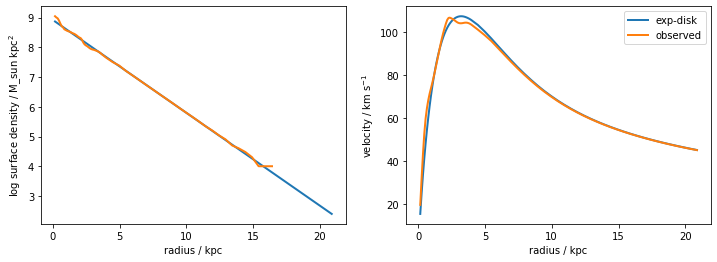

In [15]:
vd_n2403 = vcdisk.vcdisk(rad, sb_n2403, z0=0.4)# z0=0.4 kpc from Fraternali et al. (2002): https://ui.adsabs.harvard.edu/abs/2002AJ....123.3124F
sb_exp_n2403 = expdisk_sb(rad, 1.004e10, 1.39) # numbers taken from http://astroweb.cwru.edu/SPARC/

fig,ax = plt.subplots(figsize=(12,4), ncols=2)

plot_sb_vdisk(ax, rad, sb_exp_n2403, vcdisk.vcdisk(rad, sb_exp_n2403), label='exp-disk')
plot_sb_vdisk(ax, rad, sb_n2403, vd_n2403, label='observed')

The $V_{\star, \rm disk}$ curve obtained with `vcdisk` directly from the ellipse photometry of NGC 2403 is much more structured between $1-5\rm \,kpc$, which is where the surface brightness has dips and peaks. 
*Capturing this rich structure is* **essential** *to rotation curve modelling*.

### UGC 2953: an early (Sa) spiral galaxy

Let's take a different case now of an early spiral galaxy, i.e. a disk galaxy with redder colors and a prominent central bulge: UGC 2953.

I use again the data taken from the [SPARC](http://astroweb.cwru.edu/SPARC/) database and I include them here as the `UGC02953_rotmod.dat` file. There are measurements of the near-infrared intensities of both the disk and bulge components separated.

In [16]:
rad, _, _, _, _, _, sbd_u2953, sbb_u2953 = np.genfromtxt('UGC02953_rotmod.dat', unpack=True)
# convert SB to Msun / kpc^2
sbd_u2953 *= 1e6
sbb_u2953 *= 1e6

With the two different surface brightness arrays, we can use `vcdisk` and `vcbulge` to get the corresponding circular velocities.

In [17]:
vd_u2953 = vcdisk.vcdisk(rad, sbd_u2953, z0=0.6)
vb_u2953 = vcdisk.vcbulge(rad, sbb_u2953)

And we can finally plot them together.

/Users/lposti/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/Users/lposti/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/Users/lposti/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


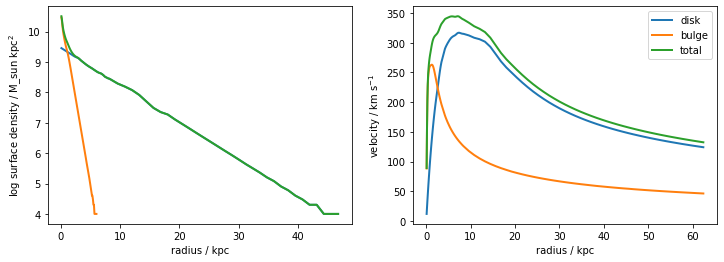

In [18]:
fig,ax = plt.subplots(figsize=(12,4), ncols=2)

plot_sb_vdisk(ax, rad, sbd_u2953, vd_u2953, label='disk')
plot_sb_vdisk(ax, rad, sbb_u2953, vb_u2953, label='bulge')
plot_sb_vdisk(ax, rad, sbd_u2953+sbb_u2953, np.sqrt(vd_u2953**2+vb_u2953**2), label='total')